In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
pd.set_option('display.max_colwidth', None)


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA


### DEFINE FUNCTIONS

In [35]:
def categorize_offence(offence):
    offence = str(offence)
    offence = offence.lower()
    if ('thef' in offence) or ('larceny' in offence) or ('stolen' in offence):
        offence = "THEFT"
    elif ('fraud' in offence) or ('fortune' in offence) or ('forgery' in offence) or ('gambling' in offence):
        offence = "FRAUD"
    elif ('burglar' in offence) or ('b&e' in offence) or ('break and enter' in offence) or ('unlawfully in' in offence) or ('trespass' in offence):
        offence = "BREAK AND ENTER"
    elif 'robbery' in offence:
        offence = "ROBBERY"
    elif ('assault' in offence) or ('disarming' in offence) or ('death' in offence) or ('off' in offence) or ('touching' in offence):
        offence = "ASSAULT"
    elif ('sex' in offence) or ('rape' in offence):
        offence = "SEX CRIMES"
    elif ('drug' in offence) or ('alcohol' in offence) or ('cannabis' in offence) or ('noxious' in offence):
        offence = "DRINKING/DRUG OFFENSES"
    elif ('homicide' in offence) or ('murder' in offence):
        offence = "MURDER"
    elif ('firearm' in offence) or ('gun' in offence) or ('bodily' in offence) or ('weap' in offence) or ('jostling' in offence):
        offence = "ASSAULT"
    elif 'kidnapping' in offence:
        offence = "KIDNAPPING"
    elif 'loitering' in offence:
        offence = "LOITERING"
    elif ('parking' in offence) or ('traffic' in offence) or ('vehicle' in offence) or ('driving' in offence):
        offence = "PARKING/TRAFFIC/VEHICLE OFFENSES"
    elif ('harassment' in offence) or ('disorderly' in offence) or ('disruption' in offence) or ('harrassment' in offence):
        offence = "DISORDERLY/DISRUPTION/HARASSMENT"
    elif ('child' in offence) or ('abortion' in offence):
        offence = "CHILD CRIMES"
    else:
        offence = 'OTHER'

    return offence

### READ DATASET

In [46]:
#Crimes in Toronto
file_name = 'NYPD_Arrests_Data__Historic__20250524.csv'

#Read dataset
NYPD_Arrests_df = pd.read_csv(file_name)

len(NYPD_Arrests_df) #5,986,025
NYPD_Arrests_df.head()
NYPD_Arrests_df.info()

5986025

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,279197226,12/19/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,M,18,0.0,25-44,M,WHITE,988210.0,218129.0,40.765390,-73.985702,POINT (-73.985702 40.76539)
1,278761840,12/09/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211300,F,K,67,0.0,25-44,M,BLACK,997897.0,175676.0,40.648859,-73.950820,POINT (-73.95082 40.648859)
2,278506761,12/05/2023,153.0,RAPE 3,104.0,RAPE,PL 1302503,F,K,77,0.0,25-44,M,BLACK,1003509.0,185018.0,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259)
3,278436408,12/03/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,B,46,0.0,45-64,M,BLACK,1011755.0,250279.0,40.853598,-73.900577,POINT (-73.9005768807295 40.8535983673823)
4,278248753,11/29/2023,660.0,(null),NaN,(null),PL 2407800,M,Q,104,0.0,<18,M,WHITE HISPANIC,1011456.0,194092.0,40.699373,-73.901881,POINT (-73.901881 40.699373)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986025 entries, 0 to 5986024
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ARREST_KEY         int64  
 1   ARREST_DATE        object 
 2   PD_CD              float64
 3   PD_DESC            object 
 4   KY_CD              float64
 5   OFNS_DESC          object 
 6   LAW_CODE           object 
 7   LAW_CAT_CD         object 
 8   ARREST_BORO        object 
 9   ARREST_PRECINCT    int64  
 10  JURISDICTION_CODE  float64
 11  AGE_GROUP          object 
 12  PERP_SEX           object 
 13  PERP_RACE          object 
 14  X_COORD_CD         float64
 15  Y_COORD_CD         float64
 16  Latitude           float64
 17  Longitude          float64
 18  Lon_Lat            object 
dtypes: float64(7), int64(2), object(10)
memory usage: 867.7+ MB


### FEATURE ENGINEERING

In [47]:
#Convert string to datetime
NYPD_Arrests_df["ARREST_DATE"] = pd.to_datetime(NYPD_Arrests_df["ARREST_DATE"])

# Extract the year
NYPD_Arrests_df["CRIME_YEAR"] = NYPD_Arrests_df["ARREST_DATE"].dt.year

#Analysis from 2014 to 2024
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["CRIME_YEAR"] >= 2014] 

# Extract the month
NYPD_Arrests_df["CRIME_MONTH"] = NYPD_Arrests_df["ARREST_DATE"].dt.month

# Extract the Day of Week
NYPD_Arrests_df["CRIME_DOW"] = NYPD_Arrests_df["ARREST_DATE"].dt.weekday


In [48]:
#Pick the valid age groups
valid_age_group_lst = ['25-44', '18-24', '45-64', '<18', '65+']
len(NYPD_Arrests_df)
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df['AGE_GROUP'].isin(valid_age_group_lst)]
len(NYPD_Arrests_df)

2762745

2762745

In [49]:
# Define a dictionary for PERP_SEX
sex_mapping = {
    'M': 'Male',
    'F': 'Female',
    'U': 'Undisclosed'
}

# Apply the mapping
NYPD_Arrests_df["PERP_SEX"] = NYPD_Arrests_df["PERP_SEX"].map(sex_mapping)
NYPD_Arrests_df["PERP_SEX"].value_counts(dropna=False)
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["PERP_SEX"] != 'Undisclosed']
NYPD_Arrests_df["PERP_SEX"].value_counts(dropna=False)


PERP_SEX
Male           2278901
Female          480340
Undisclosed       3504
Name: count, dtype: int64

PERP_SEX
Male      2278901
Female     480340
Name: count, dtype: int64

In [50]:
#Law Category Code
# Define a dictionary for LAW_CAT_CD
law_cat_cd_mapping = {
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I':'Unclassified Misdemeanors',
    '9':'Resisting/Obstruction'
}

# Apply the mapping
NYPD_Arrests_df["LAW_CAT_CD"].value_counts(dropna=False)
NYPD_Arrests_df["LAW_CAT_CD"] = NYPD_Arrests_df["LAW_CAT_CD"].map(law_cat_cd_mapping)
NYPD_Arrests_df = NYPD_Arrests_df[~NYPD_Arrests_df["LAW_CAT_CD"].isna()]
NYPD_Arrests_df["LAW_CAT_CD"].value_counts(dropna=False)


LAW_CAT_CD
M         1682654
F          967450
V           82329
NaN         15883
I            9117
9            1798
(null)         10
Name: count, dtype: int64

LAW_CAT_CD
Misdemeanor                  1682654
Felony                        967450
Violation                      82329
Unclassified Misdemeanors       9117
Resisting/Obstruction           1798
Name: count, dtype: int64

In [51]:
#Refine the offense type
NYPD_Arrests_df['TYPE_OF_OFFENSE'] = NYPD_Arrests_df['OFNS_DESC'].apply(lambda s: categorize_offence(s))
type_of_offense_lst = ['ASSAULT', 'SEX CRIMES', 'BREAK AND ENTER', 'FRAUD', 'PARKING/TRAFFIC/VEHICLE OFFENSES', 
                       'THEFT', 'DRINKING/DRUG OFFENSES', 'MURDER', 'ROBBERY']

NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["TYPE_OF_OFFENSE"].isin(type_of_offense_lst)]
NYPD_Arrests_df["TYPE_OF_OFFENSE"].value_counts(dropna=False)


TYPE_OF_OFFENSE
ASSAULT                             878820
THEFT                               535960
DRINKING/DRUG OFFENSES              351443
PARKING/TRAFFIC/VEHICLE OFFENSES    265763
BREAK AND ENTER                     117884
ROBBERY                             107758
FRAUD                                96443
SEX CRIMES                           48087
MURDER                               13851
Name: count, dtype: int64

In [52]:
#PERP_RACE
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["PERP_RACE"] != 'UNKNOWN']


In [53]:
#JURISDICTION_CODE
NYPD_Arrests_df["JURISDICTION_CODE"] = NYPD_Arrests_df["JURISDICTION_CODE"].astype(int)


In [54]:
#Drop na values
len(NYPD_Arrests_df)
NYPD_Arrests_df = NYPD_Arrests_df.dropna()
len(NYPD_Arrests_df)

NYPD_Arrests_df.head()

2397604

2397601

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,TYPE_OF_OFFENSE
0,279197226,2023-12-19,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,Felony,M,18,...,WHITE,988210.0,218129.0,40.765390,-73.985702,POINT (-73.985702 40.76539),2023,12,1,ASSAULT
1,278761840,2023-12-09,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211300,Felony,K,67,...,BLACK,997897.0,175676.0,40.648859,-73.950820,POINT (-73.95082 40.648859),2023,12,5,ASSAULT
2,278506761,2023-12-05,153.0,RAPE 3,104.0,RAPE,PL 1302503,Felony,K,77,...,BLACK,1003509.0,185018.0,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259),2023,12,1,SEX CRIMES
3,278436408,2023-12-03,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,B,46,...,BLACK,1011755.0,250279.0,40.853598,-73.900577,POINT (-73.9005768807295 40.8535983673823),2023,12,6,SEX CRIMES
5,278254593,2023-11-29,464.0,JOSTLING,230.0,JOSTLING,PL 1652501,Misdemeanor,M,18,...,WHITE HISPANIC,990503.0,215519.0,40.758225,-73.977428,POINT (-73.977428 40.758225),2023,11,2,ASSAULT


### STRATIFIED SAMPLING


In [55]:
sampling_fraction = 0.01

NYPD_Arrests_df = NYPD_Arrests_df.groupby('TYPE_OF_OFFENSE', 
                                                group_keys=False).apply(lambda x: x.sample(frac=sampling_fraction)).reset_index(drop=True)

len(NYPD_Arrests_df)
NYPD_Arrests_df.head()

NYPD_Arrests_df["TYPE_OF_OFFENSE"].value_counts(dropna=False)

C:\Users\Vanessa\AppData\Local\Temp\ipykernel_18196\1358417050.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NYPD_Arrests_df = NYPD_Arrests_df.groupby('TYPE_OF_OFFENSE',


23975

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,TYPE_OF_OFFENSE
0,151967107,2016-04-08,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,M,34,...,BLACK HISPANIC,1008739.0,256745.0,40.871354,-73.911455,POINT (-73.91145542999998 40.87135445900003),2016,4,4,ASSAULT
1,178167940,2018-04-14,113.0,"MENACING,UNCLASSIFIED",344.0,ASSAULT 3 & RELATED OFFENSES,PL 1201401,Misdemeanor,S,120,...,WHITE HISPANIC,959900.0,162479.0,40.612618,-74.087704,POINT (-74.08770362799999 40.612618456000064),2018,4,5,ASSAULT
2,228417279,2021-05-19,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,M,28,...,BLACK,997758.0,233532.0,40.807665,-73.951207,POINT (-73.951206685 40.80766516200004),2021,5,2,ASSAULT
3,148506651,2015-12-13,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,Q,103,...,BLACK,1042848.0,192383.0,40.694538,-73.788688,POINT (-73.78868763699995 40.69453789000005),2015,12,6,ASSAULT
4,226204326,2021-03-27,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,S,120,...,BLACK,951598.0,168433.0,40.628934,-74.117634,POINT (-74.11763397899993 40.62893423000003),2021,3,5,ASSAULT


TYPE_OF_OFFENSE
ASSAULT                             8732
THEFT                               5320
DRINKING/DRUG OFFENSES              3491
PARKING/TRAFFIC/VEHICLE OFFENSES    2616
BREAK AND ENTER                     1172
ROBBERY                             1073
FRAUD                                956
SEX CRIMES                           477
MURDER                               138
Name: count, dtype: int64

### FORMAT THE DATA ACCORDINGLY
- Label Encoder used to convert all strings to numbers

In [56]:
NYPD_Arrests_ML_df = NYPD_Arrests_df

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform
NYPD_Arrests_ML_df["ARREST_BORO_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["ARREST_BORO"].to_list())

NYPD_Arrests_ML_df["AGE_GROUP_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["AGE_GROUP"].to_list())

NYPD_Arrests_ML_df["PERP_SEX_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["PERP_SEX"].to_list())

NYPD_Arrests_ML_df["PERP_RACE_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["PERP_RACE"].to_list())

NYPD_Arrests_ML_df["TYPE_OF_OFFENSE_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["TYPE_OF_OFFENSE"].to_list())

NYPD_Arrests_ML_df["LAW_CAT_CD_LE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["LAW_CAT_CD"].to_list())


#Curate the dataset for building the ML unsupervised KMeans model
ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO_LE', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP_LE', 'PERP_SEX_LE', 'PERP_RACE_LE', 'TYPE_OF_OFFENSE_LE', 'LAW_CAT_CD_LE']

NYPD_Arrests_ML_df = NYPD_Arrests_ML_df[ml_col_lst]

NYPD_Arrests_ML_df.head()
NYPD_Arrests_ML_df.info()

,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO_LE,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP_LE,PERP_SEX_LE,PERP_RACE_LE,TYPE_OF_OFFENSE_LE,LAW_CAT_CD_LE
0,2016,4,4,2,34,0,4,1,3,0,1
1,2018,4,5,4,120,0,0,1,5,0,1
2,2021,5,2,2,28,0,1,1,2,0,1
3,2015,12,6,3,103,0,0,1,2,0,1
4,2021,3,5,4,120,0,1,1,2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23975 entries, 0 to 23974
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   CRIME_YEAR          23975 non-null  int32
 1   CRIME_MONTH         23975 non-null  int32
 2   CRIME_DOW           23975 non-null  int32
 3   ARREST_BORO_LE      23975 non-null  int64
 4   ARREST_PRECINCT     23975 non-null  int64
 5   JURISDICTION_CODE   23975 non-null  int32
 6   AGE_GROUP_LE        23975 non-null  int64
 7   PERP_SEX_LE         23975 non-null  int64
 8   PERP_RACE_LE        23975 non-null  int64
 9   TYPE_OF_OFFENSE_LE  23975 non-null  int64
 10  LAW_CAT_CD_LE       23975 non-null  int64
dtypes: int32(4), int64(7)
memory usage: 1.6 MB


### INVESTIGATE THE DISTRIBUTION OF CATEGORICAL VARIABLES


In [57]:
ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO_LE', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP_LE', 'PERP_SEX_LE', 'PERP_RACE_LE', 'TYPE_OF_OFFENSE_LE', 'LAW_CAT_CD_LE']

for col in ml_col_lst:
    NYPD_Arrests_ML_df[col].value_counts(dropna=False)


CRIME_YEAR
2014    3324
2015    2837
2016    2823
2017    2556
2024    2250
2018    2201
2023    2015
2019    1862
2022    1592
2021    1320
2020    1195
Name: count, dtype: int64

CRIME_MONTH
3     2237
5     2146
8     2102
10    2084
1     2052
6     2027
7     1971
4     1970
9     1958
2     1885
11    1884
12    1659
Name: count, dtype: int64

CRIME_DOW
2    4159
3    3982
4    3609
1    3592
5    3277
0    2888
6    2468
Name: count, dtype: int64

ARREST_BORO_LE
1    6416
2    6312
0    5565
3    4680
4    1002
Name: count, dtype: int64

ARREST_PRECINCT
14     806
40     799
75     702
44     689
52     561
      ... 
111    118
94     112
123    106
22      16
116      1
Name: count, Length: 78, dtype: int64

JURISDICTION_CODE
0     20699
1      1620
2      1012
3       211
97      174
72       59
4        34
17       30
73       26
11       24
6        21
15       14
7        14
14       11
71        6
69        6
87        4
9         3
12        3
88        2
51        1
16        1
Name: count, dtype: int64

AGE_GROUP_LE
1    12347
0     5269
2     4775
4     1300
3      284
Name: count, dtype: int64

PERP_SEX_LE
1    19609
0     4366
Name: count, dtype: int64

PERP_RACE_LE
2    11612
5     6259
4     2670
3     2199
1     1165
0       70
Name: count, dtype: int64

TYPE_OF_OFFENSE_LE
0    8732
8    5320
2    3491
5    2616
1    1172
6    1073
3     956
7     477
4     138
Name: count, dtype: int64

LAW_CAT_CD_LE
1    16027
0     7892
3       54
2        1
4        1
Name: count, dtype: int64

### UNSUPERVISED KMEANS

,Cluster #,Inertia
0,1,3.201011e+07
1,2,1.044544e+07
2,3,6.466525e+06
3,4,4.613593e+06
4,5,2.494505e+06


<AxesSubplot:xlabel='Cluster #'>

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'Inertia for each Number of Clusters')

<Figure size 1500x1500 with 0 Axes>

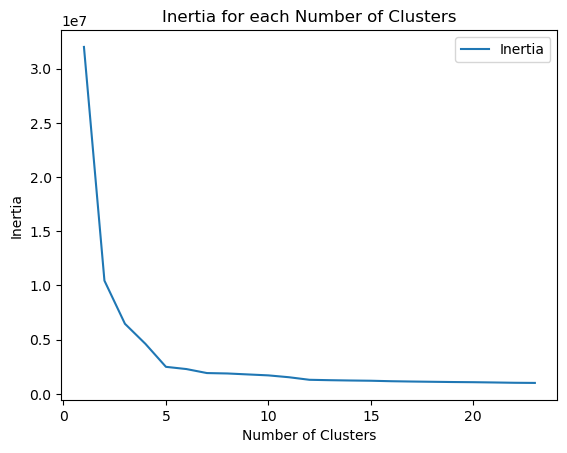

In [58]:
#Pick the optimal number of clusters/topics based on Inertia - Within CLuster Sum of Squares
inertia = {}
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
    km = KMeans(n_clusters=int(i), init='k-means++', max_iter=100, n_init=1, random_state = 42).fit(NYPD_Arrests_ML_df)
    inertia[i] =km.inertia_ 

inertia = pd.DataFrame({"Cluster #":list(inertia.keys()),"Inertia":list(inertia.values())})
inertia.head()

y1 = plt.figure(figsize=(15, 15))
inertia.plot(x='Cluster #', y='Inertia')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia for each Number of Clusters")

### GET THE KMEANS LABELS

In [59]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1, random_state = 42).fit(NYPD_Arrests_ML_df)
km_labels_test = km.predict(NYPD_Arrests_ML_df)

#Distribution
value_counts = Counter(km_labels_test)
value_counts

Counter({0: 11691, 1: 5755, 2: 6252, 3: 277})

### VISUALISE THE CLUSTERS

In [60]:
pca_model = PCA(n_components=2)
X_reduced = pca_model.fit_transform(NYPD_Arrests_ML_df)

X_reduced = pd.DataFrame(X_reduced)

X_reduced["KMeans Cluster"] = list(km_labels_test)
X_reduced["KMeans Cluster"].value_counts(dropna=False)

X_reduced.columns = ["x_axis", "y_axis","KMeans Cluster"]
X_reduced

KMeans Cluster
0    11691
2     6252
1     5755
3      277
Name: count, dtype: int64

,x_axis,y_axis,KMeans Cluster
0,-27.291263,-1.464755,0
1,58.728224,-0.683571,1
2,-33.281297,-1.523375,0
3,41.705617,-0.800110,1
4,58.735321,-0.686642,1
...,...,...,...
23970,45.675175,-0.952394,1
23971,-27.339579,-1.619131,0
23972,53.643953,0.171905,1
23973,-14.384735,-0.470945,0


<Figure size 1200x1200 with 0 Axes>

<AxesSubplot:xlabel='x_axis', ylabel='y_axis'>

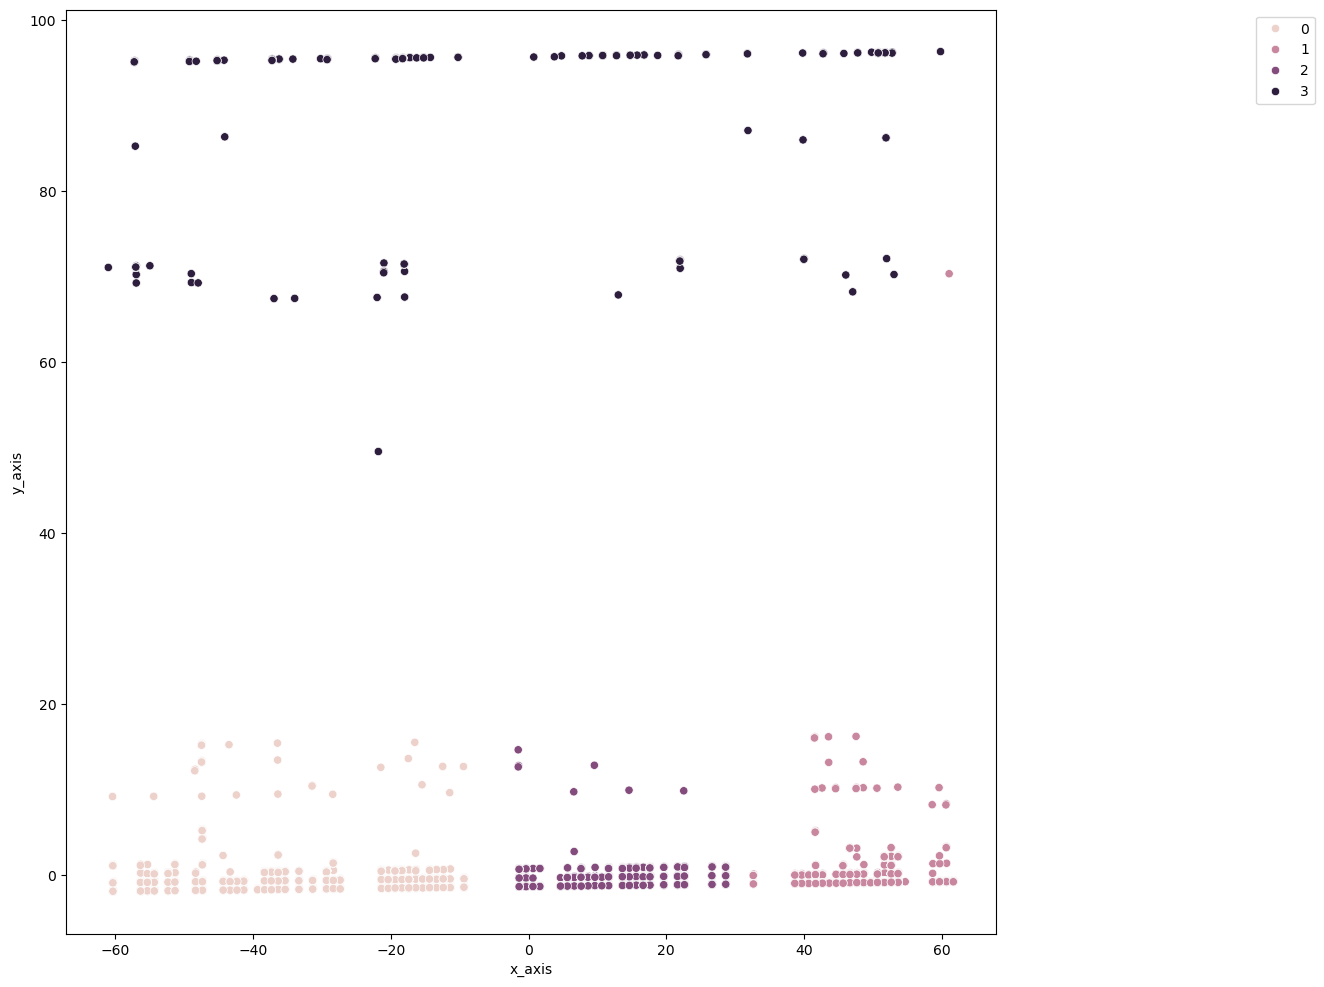

In [61]:
plt.figure(figsize=(12, 12))
sns.scatterplot(x="x_axis", y="y_axis", hue="KMeans Cluster", data=X_reduced)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))

### EXPLORATORY DATA ANALYSIS OF EACH CLUSTER

In [62]:
#Assign the cluster labels to each row of the data
NYPD_Arrests_df["KMeans Cluster"] = list(km_labels_test)
len(NYPD_Arrests_df)
NYPD_Arrests_df.head(2)

23975

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,CRIME_MONTH,CRIME_DOW,TYPE_OF_OFFENSE,ARREST_BORO_LE,AGE_GROUP_LE,PERP_SEX_LE,PERP_RACE_LE,TYPE_OF_OFFENSE_LE,LAW_CAT_CD_LE,KMeans Cluster
0,151967107,2016-04-08,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,M,34,...,4,4,ASSAULT,2,4,1,3,0,1,0
1,178167940,2018-04-14,113.0,"MENACING,UNCLASSIFIED",344.0,ASSAULT 3 & RELATED OFFENSES,PL 1201401,Misdemeanor,S,120,...,4,5,ASSAULT,4,0,1,5,0,1,1


In [64]:
cluster_0_df = NYPD_Arrests_df[NYPD_Arrests_df["KMeans Cluster"] == 0]
len(cluster_0_df)

ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'TYPE_OF_OFFENSE', 'LAW_CAT_CD']

for col in ml_col_lst:
    cluster_0_df[col].value_counts(dropna=False)


11691

CRIME_YEAR
2014    1650
2015    1419
2016    1399
2017    1272
2024    1047
2018    1040
2023     969
2019     878
2022     806
2021     645
2020     566
Name: count, dtype: int64

CRIME_MONTH
5     1090
3     1057
10    1054
8     1013
6     1010
1     1006
7      956
9      955
4      951
11     930
2      895
12     774
Name: count, dtype: int64

CRIME_DOW
2    2031
3    1908
1    1807
4    1772
5    1577
0    1425
6    1171
Name: count, dtype: int64

ARREST_BORO
M    6234
B    5457
Name: count, dtype: int64

ARREST_PRECINCT
14    804
40    790
44    669
52    558
46    544
25    491
43    483
47    466
48    442
42    408
18    388
41    353
34    349
23    330
28    326
49    317
5     313
32    312
6     282
13    280
33    276
19    269
45    265
30    248
1     248
7     246
9     243
10    191
24    188
50    162
26    159
20    157
17    118
22     16
Name: count, dtype: int64

JURISDICTION_CODE
0     9908
1     1008
2      608
3       78
17      20
15      14
7       14
6       13
4       10
11       9
14       6
12       3
Name: count, dtype: int64

AGE_GROUP
25-44    6066
18-24    2491
45-64    2384
<18       608
65+       142
Name: count, dtype: int64

PERP_SEX
Male      9518
Female    2173
Name: count, dtype: int64

PERP_RACE
BLACK                             5446
WHITE HISPANIC                    3364
BLACK HISPANIC                    1577
WHITE                             1006
ASIAN / PACIFIC ISLANDER           278
AMERICAN INDIAN/ALASKAN NATIVE      20
Name: count, dtype: int64

TYPE_OF_OFFENSE
ASSAULT                             4025
THEFT                               2882
DRINKING/DRUG OFFENSES              1856
PARKING/TRAFFIC/VEHICLE OFFENSES    1061
BREAK AND ENTER                      595
ROBBERY                              517
FRAUD                                474
SEX CRIMES                           200
MURDER                                81
Name: count, dtype: int64

LAW_CAT_CD
Misdemeanor                  7999
Felony                       3676
Unclassified Misdemeanors      15
Resisting/Obstruction           1
Name: count, dtype: int64

In [65]:
cluster_1_df = NYPD_Arrests_df[NYPD_Arrests_df["KMeans Cluster"] == 1]
len(cluster_1_df)

ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'TYPE_OF_OFFENSE', 'LAW_CAT_CD']

for col in ml_col_lst:
    cluster_1_df[col].value_counts(dropna=False)


5755

CRIME_YEAR
2014    768
2015    656
2016    650
2024    609
2017    555
2018    544
2023    515
2019    460
2022    391
2021    339
2020    268
Name: count, dtype: int64

CRIME_MONTH
3     547
5     519
10    501
6     494
8     493
1     485
4     476
9     462
7     458
2     453
11    434
12    433
Name: count, dtype: int64

CRIME_DOW
2    986
3    967
1    873
4    824
5    791
0    704
6    610
Name: count, dtype: int64

ARREST_BORO
Q    4643
S    1001
K     109
M       2
Name: count, dtype: int64

ARREST_PRECINCT
103    513
113    489
120    428
115    407
114    384
110    383
109    362
105    305
121    285
106    271
102    265
104    246
107    209
108    197
101    183
122    182
112    173
100    139
111    118
94     109
123    106
116      1
Name: count, dtype: int64

JURISDICTION_CODE
0     5337
1      162
3      133
2       64
4       23
11      12
17      10
6        8
9        3
14       2
71       1
Name: count, dtype: int64

AGE_GROUP
25-44    2935
18-24    1366
45-64    1065
<18       315
65+        74
Name: count, dtype: int64

PERP_SEX
Male      4699
Female    1056
Name: count, dtype: int64

PERP_RACE
BLACK                             2190
WHITE HISPANIC                    1687
WHITE                              896
ASIAN / PACIFIC ISLANDER           635
BLACK HISPANIC                     305
AMERICAN INDIAN/ALASKAN NATIVE      42
Name: count, dtype: int64

TYPE_OF_OFFENSE
ASSAULT                             2290
THEFT                               1081
PARKING/TRAFFIC/VEHICLE OFFENSES     825
DRINKING/DRUG OFFENSES               690
BREAK AND ENTER                      250
ROBBERY                              247
FRAUD                                195
SEX CRIMES                           161
MURDER                                16
Name: count, dtype: int64

LAW_CAT_CD
Misdemeanor                  3814
Felony                       1921
Unclassified Misdemeanors      19
Violation                       1
Name: count, dtype: int64